<a href="https://colab.research.google.com/github/VelasquezE/ML4Sci_2025-II/blob/main/Module2/clasficadorTexto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificador de texto**

# 0. Importar las librerías necesarias

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score

import pickle
from ipywidgets import FileUpload, VBox, Button, Output, Text
import io

In [33]:
# Personalización gráficas

sns.set_style("darkgrid")

custom_rc = {
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.edgecolor": "black",
    "grid.color": "#bbbbbb",
    "grid.linestyle": "dashed",
    "axes.grid": True,
    "axes.spines.top": True,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": True
}
sns.set_context("notebook")
sns.set_style("darkgrid", rc = custom_rc)

# 1. Cargar los datos de entrenamiento

Se descargan los archivos csv de un repositorio de GitHub.
Luego, se carga el contenido en un DataFrame de pandas para su posterior análisis.

In [34]:
def get_data(name):
    """
    Descarga un archivo csv dado el nombre del archivo.
    Carga los datos en un DataFrame.

    Returns:
        pandas.DataFrame: Datos extraídos.
    """
    base_url = "https://raw.githubusercontent.com/VelasquezE/ML4Sci_2025-II/refs/heads/main/Module2/"
    url = base_url + name
    output_file = name
    !wget -O {output_file} {url}

    data = pd.read_csv(output_file)
    return data

In [35]:
file_name = "exc_03_train.csv"

data = get_data(file_name)

--2025-11-28 13:40:58--  https://raw.githubusercontent.com/VelasquezE/ML4Sci_2025-II/refs/heads/main/Module2/exc_03_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628989 (1.6M) [text/plain]
Saving to: ‘exc_03_train.csv’

exc_03_train.csv    100%[===================>]   1.55M  --.-KB/s    in 0.06s   

2025-11-28 13:40:58 (27.0 MB/s) - ‘exc_03_train.csv’ saved [1628989/1628989]



Obsérvese la información básica de los datos,

In [36]:
data.head()

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot o...,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
dtypes: object(3)
memory usage: 203.9+ KB


In [38]:
data["Topic"].value_counts()

,count
Topic,
Biology,3591
Chemistry,2920
Physics,2184


# 2. Pre-procesamiento de los datos

Se empieza limpiando los datos. Se eliminan los caracteres especiales (números, puntuación, símbolos), se dejan las palabras en minúscula, la lematización convierte una palabra a su forma base (cars -> car), y quita las "stopwords" es decir "the, a, an, in, on, with...".

In [39]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [49]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str):
  """
  Receives a text and deletes special caracters,
  stop words, turns to lowercase, and applies
  lemmatization.

  Parameters:
    text (str)

  Returns:
    Clean text.
  """
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = text.lower()
  words = text.split()
  words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

  return  " ".join(words)


def clean_text_batch(texts):
  return [clean_text(t) for t in texts]

# 3. Crear pipeline

Se crea un pipeline que realizará los siguientes pasos:
1.   Aplicará la función creada para limpieza del texto
2.   Vectoriza el texto en palabras
3.   Aplica el modelo de clasificación



In [41]:
def create_pipeline(classifier):
  pipeline = Pipeline([
      ("cleaner", FunctionTransformer(clean_text_batch)),
      ("tfidf", TfidfVectorizer()),
      ("clf", classifier)
  ])

  return pipeline

# 4. División de los datos

Se dividen los datos en un dataset de entrenamiento (80%) y otro de prueba (20%).

In [42]:
seed = 19
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(data["Comment"], data["Topic"], test_size=test_size, random_state=seed)

# 5. Creación de los modelos

Se aplica `MultinomialNB()` y `ComplementNB()`.

In [43]:
pipe_nb = create_pipeline(MultinomialNB())
pipe_nbc = create_pipeline(ComplementNB())

pipe_nb.fit(X_train, y_train)
predict_nb = pipe_nb.predict(X_test)
pipe_nbc.fit(X_train, y_train)
predict_nbc = pipe_nbc.predict(X_test)

# 6. Evaluación de los modelos

Se calcula la precisión,

In [44]:
accuracy_nb = accuracy_score(y_test, predict_nb)
accuracy_nbc = accuracy_score(y_test, predict_nbc)

print(f'Accuracy MultinomialNB(): {(accuracy_nb * 100):.2f}%')
print(f'Accuracy ComplementNB(): {(accuracy_nbc * 100):.2f}%')


Accuracy MultinomialNB(): 68.60%
Accuracy ComplementNB(): 74.58%


Se grafica la matriz de confusión,

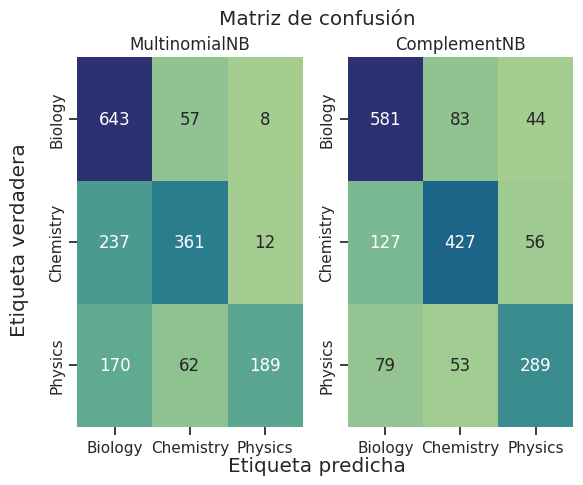

In [55]:
conf_matrix_nb = confusion_matrix(y_test, predict_nb)
conf_matrix_nbc = confusion_matrix(y_test, predict_nbc)

class_labels = np.unique(y_train)

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.heatmap(conf_matrix_nb,
            ax = ax1,
            annot=True,
            fmt='d',
            cmap='crest',
            cbar = False,
            xticklabels=class_labels,
            yticklabels=class_labels)
sns.heatmap(conf_matrix_nbc,
            ax = ax2,
            annot=True,
            fmt='d',
            cmap='crest',
            cbar = False,
            xticklabels=class_labels,
            yticklabels=class_labels)
ax1.set_title('MultinomialNB')
ax2.set_title('ComplementNB')
fig.suptitle('Matriz de confusión')
fig.supxlabel('Etiqueta predicha')
fig.supylabel('Etiqueta verdadera')
fig.savefig("confusion_matrix.jpg", dpi = 400)
plt.show()

Y, se aplica validación cruzada,

In [47]:
models = [
    ("MultinomialNB", MultinomialNB()),
    ("ComplementNB", ComplementNB()),
]

for name, clf in models:
    pipeline = create_pipeline(clf)
    scores = cross_val_score(pipeline, data["Comment"], data["Topic"], cv=5, scoring='accuracy')
    print(f"{name} → Mean accuracy: {scores.mean():.4f}")

MultinomialNB → Mean accuracy: 0.6660
ComplementNB → Mean accuracy: 0.7334


# 7. Selección de modelo final

El método `ComplementNB()` fue el que realizó una mejor clasificación. Así, este se presentará como modelo final. Además, ya que se hicieron las pruebas, se entrena con todo el conjunto de datos.

In [57]:
model = create_pipeline(ComplementNB())
model.fit(data["Comment"], data["Topic"])

Pipeline(steps=[('cleaner',
                 FunctionTransformer(func=<function clean_text_batch at 0x7eb07683ccc0>)),
                ('tfidf', TfidfVectorizer()), ('clf', ComplementNB())])

Se guarda el modelo entrenado con `pickle`.

In [61]:
filename = 'text_classifier_model.sav'
pickle.dump(model, open(filename, 'wb'))

Se crea una función que permita al usuario ingresar nuevos mensajes:

In [62]:
def predict_category(text:str, model=model):
  predicted_label = model.predict([text])

  print(f"The input text belongs to the '{predicted_label[0]}' category.")

In [63]:
new_message = "I love spacecrafts"
predict_category(new_message, model)

The input text belongs to the 'Physics' category.


In [64]:
new_message = "Hormones are crazy"
predict_category(new_message, model)

The input text belongs to the 'Biology' category.


También, para que sea cómodo para el usuario, se crea una pequeña interfaz que solicite un nuevo conjunto de datos y calcule la matriz de confusión.

In [87]:
uploader = FileUpload(accept='.csv', multiple=False)

print("Por favor suba el archivo y escriba los nombres de las columnas para identificar\n"+
      "cuál corresponde a los comentarios y cuál a las etiquetas:")

text_column = Text(description="Columna texto: ",
                        style = {'description_width': 'initial'})
label_column = Text(description="Columna etiquetas: ",
                         style = {'description_width': 'initial'})

button = Button(description="Evaluar modelo")
out = Output()

def evaluate_model(model):
    out.clear_output()
    with out:
        if not uploader.value:
            print("Por favor, suba un archivo CSV primero.")
            return

        uploaded = list(uploader.value.values())[0]
        data = pd.read_csv(io.BytesIO(uploaded['content']))
        text_column_name = text_column.value.strip()
        label_column_name = label_column.value.strip()

        if text_column_name not in data.columns:
            print(f"La columna '{text_column_name}' no existe en el archivo.")
            return

        if label_column_name not in data.columns:
            print(f"La columna '{label_column_name}' no existe en el archivo.")
            return

        X_test = data[text_column_name]
        y_true = data[label_column_name]

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_true, y_pred)
        print(f'Accuracy: {(accuracy * 100):.2f}%')

        cm = confusion_matrix(y_true, y_pred)
        class_labels = np.unique(y_true)

        sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='crest',
            cbar = False,
            xticklabels=class_labels,
            yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


button.on_click(lambda event: evaluate_model(model))

display(VBox([uploader, text_column, label_column, button, out]))

Por favor suba el archivo y escriba los nombres de las columnas para identificar
cuál corresponde a los comentarios y cuál a las etiquetas:
